In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pgdattack-resnet50/mnist_resnet50.pt


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import Tensor
torch.manual_seed(42)
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models, utils
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import torchvision.utils

In [3]:
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 10

In [4]:
normalize = transforms.Normalize((0.5,), (0.5,))

# define transforms
transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    normalize])

trainset = torchvision.datasets.MNIST(root=' MNIST/raw/train-images-idx3-ubyte', train=True, download=True, transform=transform)
mnist_trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='MNIST/raw/t10k-images-idx3-ubyte', train=False, download=True, transform=transform)
mnist_testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9') 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting  MNIST/raw/train-images-idx3-ubyte/MNIST/raw/train-images-idx3-ubyte.gz to  MNIST/raw/train-images-idx3-ubyte/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting  MNIST/raw/train-images-idx3-ubyte/MNIST/raw/train-labels-idx1-ubyte.gz to  MNIST/raw/train-images-idx3-ubyte/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting  MNIST/raw/train-images-idx3-ubyte/MNIST/raw/t10k-images-idx3-ubyte.gz to  MNIST/raw/train-images-idx3-ubyte/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting  MNIST/raw/train-images-idx3-ubyte/MNIST/raw/t10k-labels-idx1-ubyte.gz to  MNIST/raw/train-images-idx3-ubyte/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw/t10k-images-idx3-ubyte/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw/t10k-images-idx3-ubyte/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw/t10k-images-idx3-ubyte/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw/t10k-images-idx3-ubyte/MNIST/raw



In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

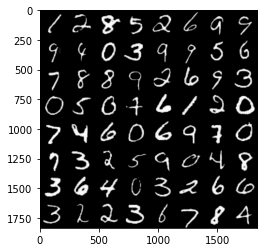

1 2 8 5 2 6 9 9 9 4 0 3 9 9 5 6 7 8 8 9 2 6 9 3 0 5 0 7 6 1 2 0


In [6]:
def imshow(img):
    img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(mnist_trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%s' % classes[labels[j]] for j in range(32)))

In [ ]:
# Train the model
def train(model, train_loader, test_loader, criterion, optimizer, num_epoch):
    for epochs in range(num_epochs):
        print("Epoch number %d " % (epochs + 1))
        model.train()
        running_loss = 0 
        running_correct = 0
        total = 0

        for data in train_loader:
            images, labels = data
            # images, labels = images.to(device), labels.to(device) 
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
      
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
      
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100 * running_correct/total

        print("Training \n Got %d out of %d images correctely (%.3f%%). Epoch loss: %.3f" %(running_correct, total, epoch_acc, epoch_loss))
    return model

In [ ]:
def evaluate(model, test_loader): # Evaluate accuracy on test set
    model.eval() # Set the model to evaluation mode  
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            epoch_acc = 100 * correct/total

    print("Testing \n Got %d out of %d images correctely (%.3f%%)." %(correct, total, epoch_acc))

In [ ]:
import torchvision.models as models
mnist_resnet50 = models.resnet50()
print(mnist_resnet50)

In [ ]:
mnist_resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
mnist_resnet50.fc = nn.Linear(2048,10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mnist_resnet50.parameters(), lr=learning_rate, weight_decay=0.001)
model = mnist_resnet50.to(device)

In [ ]:
train(mnist_resnet50, mnist_trainloader, mnist_testloader, criterion, optimizer, num_epochs)

In [ ]:
print("Evaluation on Test Set... ")
evaluate(mnist_resnet50, mnist_testloader)

In [ ]:
model_save_name = 'mnist_resnet50.pt'
path = f"./{model_save_name}" 
torch.save(mnist_resnet50, path)

## PGD Attack

In [3]:
normalize = transforms.Normalize((0.5,), (0.5,))

# define transforms
transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    normalize])

testset = torchvision.datasets.MNIST(root='MNIST/raw/t10k-images-idx3-ubyte', train=False, download=True, transform=transform)
mnist_testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw/t10k-images-idx3-ubyte/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw/t10k-images-idx3-ubyte/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw/t10k-images-idx3-ubyte/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw/t10k-images-idx3-ubyte/MNIST/raw



In [4]:
def evaluate(model, test_loader):# Evaluate accuracy on test set
    model.eval() # Set the model to evaluation mode  
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            epoch_acc = 100 * correct/total

    print("Testing \n Got %d out of %d images correctely (%.3f%%)." %(correct, total, epoch_acc))

In [5]:
def pgd_attack(model, images, labels, eps, alpha, steps):
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    original_images = images.data
        
    for i in range(steps) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - original_images, min=-eps, max=eps)
        images = torch.clamp(original_images + eta, min=0, max=1).detach_()
            
    return images

In [6]:
def test( model, device, test_loader, eps, alpha, steps ):
    # Accuracy counter
    correct = 0
    adv_examples = []
    model.eval()
    # Loop over all examples in test set
    for data in testloader:
        images, labels = data
        images, labels= images.to(device), labels.to(device)
        outputs = model(images)
        
        #Prediction before adversarial attack
        #init_pred = model(image)
        #init_pred = init_pred.max(1, keepdim=True)[1]  
        
        # Call PGD Attack
        adv_images = pgd_attack(model, images, labels, eps, alpha, steps)
        adv_pred = model(adv_images)
        _, predicted = torch.max(adv_pred.data, 1)
        correct += (predicted == labels).sum().item()

        # get the index of the max log-probability
        #final_pred = adv_pred.max(1, keepdim=True)[1]  
        #if final_pred.item() == label.item():
        #    correct += 1
        #else:
            # Saving adversarial examples for visualization later
        #    adv_ex = adv_image.squeeze().detach().cpu().numpy()
        #    adv_examples.append( (label.item(), init_pred.item(), final_pred.item(), image.squeeze().detach().cpu().numpy(), adv_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Step: {}\nTest Accuracy = {} / {} = {}".format(steps, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
PATH = F"../input/pgdattack-resnet50/mnist_resnet50.pt" 
model = torch.load(PATH, map_location=torch.device('cpu'))
model = model.to(device)

In [9]:
eps = 25/255
alpha = 0.001
testloader = mnist_testloader
print("Performing a PGD attack with Step 1..")
acc1, example1 = test(model, device, testloader, eps, alpha, 1)
print("Performing a PGD attack with Steps 2..")
acc2, example2 = test(model, device, testloader, eps, alpha, 2)
print("Performing a PGD attack with Steps 5..")
acc5, example5 = test(model, device, testloader, eps, alpha, 5)
print("Performing a PGD attack with Steps 10..")
acc10, example10 = test(model, device, testloader, eps, alpha, 10)

Performing a PGD attack with Step 1..
Step: 1
Test Accuracy = 419 / 10000 = 0.0419
Performing a PGD attack with Steps 2..
Step: 2
Test Accuracy = 390 / 10000 = 0.039
Performing a PGD attack with Steps 5..
Step: 5
Test Accuracy = 319 / 10000 = 0.0319
Performing a PGD attack with Steps 10..
Step: 10
Test Accuracy = 208 / 10000 = 0.0208


In [10]:
eps = 25/255
alpha = 0.005
testloader = mnist_testloader
print("Performing a PGD attack with Step 1..")
acc1, example1 = test(model, device, testloader, eps, alpha, 1)
print("Performing a PGD attack with Steps 2..")
acc2, example2 = test(model, device, testloader, eps, alpha, 2)
print("Performing a PGD attack with Steps 5..")
acc5, example5 = test(model, device, testloader, eps, alpha, 5)
print("Performing a PGD attack with Steps 10..")
acc10, example10 = test(model, device, testloader, eps, alpha, 10)

Performing a PGD attack with Step 1..
Step: 1
Test Accuracy = 420 / 10000 = 0.042
Performing a PGD attack with Steps 2..
Step: 2
Test Accuracy = 296 / 10000 = 0.0296
Performing a PGD attack with Steps 5..
Step: 5
Test Accuracy = 83 / 10000 = 0.0083
Performing a PGD attack with Steps 10..
Step: 10
Test Accuracy = 13 / 10000 = 0.0013


In [11]:
eps = 25/255
alpha = 0.01
testloader = mnist_testloader
print("Performing a PGD attack with Step 1..")
acc1, example1 = test(model, device, testloader, eps, alpha, 1)
print("Performing a PGD attack with Steps 2..")
acc2, example2 = test(model, device, testloader, eps, alpha, 2)
print("Performing a PGD attack with Steps 5..")
acc5, example5 = test(model, device, testloader, eps, alpha, 5)
print("Performing a PGD attack with Steps 10..")
acc10, example10 = test(model, device, testloader, eps, alpha, 10)

Performing a PGD attack with Step 1..
Step: 1
Test Accuracy = 416 / 10000 = 0.0416
Performing a PGD attack with Steps 2..
Step: 2
Test Accuracy = 199 / 10000 = 0.0199
Performing a PGD attack with Steps 5..
Step: 5
Test Accuracy = 23 / 10000 = 0.0023
Performing a PGD attack with Steps 10..
Step: 10
Test Accuracy = 0 / 10000 = 0.0
